# Eval 100 SDG vs Human with Controlled Distribution

In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

with open("./json/human_out.json", 'r') as json_file:
    human_data = json.load(json_file)
with open("./json/sdg_out.json", 'r') as json_file:
    sdg_data = json.load(json_file)
with open("./json/human_eval.json", 'r') as json_file:
    human_eval_vlm = json.load(json_file)
with open("./json/sdg_eval.json", 'r') as json_file:
    sdg_eval_vlm = json.load(json_file)

    
COL_D = {
    'factoid' : 'accuracy',
    'r0' : 'logic',
    'r1' : 'clarity',
    'r2' : 'detail',
    'r3' : 'irrelevance',
    'r4' : 'plausibility'
}   
    
# Human-made data [id, subject_id, img_id, time, q, sa, r]
# Human-made data eval 
# By VLM ~ [id, accuracy, logic, clarity, detail, irrelevance, plaus] 
# By Human ~ [id, factoid, r0, r1,r2,r3,r4]
df_human_data = pd.DataFrame(human_data)
df_human_eval_vlm = pd.DataFrame(human_eval_vlm)[['id', 'accuracy', 'logic', 'clarity', 'detail', 'irrelevance', 'plausibility']]
df_human_eval_human = pd.read_csv(r'./csv/human_graded.csv', sep = ';').rename(columns = COL_D)


# Synthetic data [id, img_id, q, sa, r]
# Synthetic data eval 
# By VLM ~ [id, accuracy, logic, clarity, detail, irrelevance, plaus] 
# By Human ~ [id, factoid, r0, r1,r2,r3,r4]
df_sdg_data = pd.DataFrame(sdg_data)
df_sdg_eval_vlm = pd.DataFrame(sdg_eval_vlm)
df_sdg_eval_human = pd.read_csv(r'./csv/sdg_graded.csv', sep = ';').rename(columns = COL_D)

df_human_data['id'] = df_human_data['id'].astype(float)
df_human_eval_vlm['id'] = df_human_eval_vlm['id'].astype(float)
df_human_eval_human['id'] = df_human_eval_human['id'].astype(float)
df_sdg_data['id'] = df_sdg_data['id'].astype(float)
df_sdg_eval_vlm['id'] = df_sdg_eval_vlm['id'].astype(float)
df_sdg_eval_human['id'] = df_sdg_eval_human['id'].astype(float)

/tmp/ipykernel_25518/1219769836.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
display(df_human_data.head(2))
print("VLM")
display(df_human_eval_vlm.head(2))
print("Human")
display(df_human_eval_human.head(2))

,id,subject_id,img_id,time,question,short_answer,reasoned_answer
0,1.0,1.0,sample_001,538.0,What time does the photo is taken?,Approximately at afternoon around 1 PM,Because it is very sunny and there is no exist...
1,2.0,1.0,sample_001,538.0,Why the man carrying a purple backpack?,Because he is carrying things for the baby,"The man is pushing a stroller, which indicates..."


VLM


,id,accuracy,logic,clarity,detail,irrelevance,plausibility
0,1.0,3,3,3,1,1,3
1,2.0,3,3,3,1,1,3


Human


,id,accuracy,logic,clarity,detail,irrelevance,plausibility
0,1.0,3.0,3.0,3.0,3.0,1.0,3.0
1,2.0,3.0,3.0,3.0,3.0,1.0,3.0


In [3]:
df_human = pd.merge(
    df_human_data, df_human_eval_vlm,
    how = 'inner',
    on = 'id',
    suffixes=('','_vlm')
)
df_human = pd.merge(
    df_human, df_human_eval_human,
    how = 'inner',
    on = 'id',
    suffixes = ('', '_human')
)

df_sdg = pd.merge(
    df_sdg_data, df_sdg_eval_vlm,
    how = 'inner',
    on = 'id',
    suffixes = ('', '_vlm')
)

df_sdg = pd.merge(
    df_sdg, df_sdg_eval_human,
    how = 'inner',
    on = 'id',
    suffixes = ('', '_human')
)

In [4]:
# Assuming df_human and df_sdg are your DataFrames
df_human = df_human[df_human['id'].isin(df_sdg['id'])]
df_sdg = df_sdg[df_sdg['id'].isin(df_human['id'])]

df_human.shape, df_sdg.shape

((65, 19), (65, 18))

In [5]:
display(df_human.head(3))
display(df_sdg.head(3))

,id,subject_id,img_id,time,question,short_answer,reasoned_answer,accuracy,logic,clarity,detail,irrelevance,plausibility,accuracy_human,logic_human,clarity_human,detail_human,irrelevance_human,plausibility_human
0,1.0,1.0,sample_001,538.0,What time does the photo is taken?,Approximately at afternoon around 1 PM,Because it is very sunny and there is no exist...,3,3,3,1,1,3,3.0,3.0,3.0,3.0,1.0,3.0
1,2.0,1.0,sample_001,538.0,Why the man carrying a purple backpack?,Because he is carrying things for the baby,"The man is pushing a stroller, which indicates...",3,3,3,1,1,3,3.0,3.0,3.0,3.0,1.0,3.0
2,3.0,1.0,sample_001,538.0,Why there is a lobster logo on the middle food...,Because it is selling a lobster,Because there is a lobster logo on it.,3,3,3,1,1,3,2.0,3.0,2.0,1.0,1.0,1.0


,id,img_id,question,short_answer,reasoned_answer,accuracy,logic,clarity,detail,irrelevance,plausibility,accuracy_human,logic_human,clarity_human,detail_human,irrelevance_human,plausibility_human,duplicate
0,1.0,sample_009,What is the primary purpose of the desk?,A workspace,The desk serves as a workspace for someone who...,3,3,3,2,2,3,3,3,3,3,3,3,0
1,2.0,sample_009,Where is the clock positioned on the desk?,Right side,The clock is positioned towards the right side...,3,3,3,1,1,1,3,3,3,3,1,3,0
2,3.0,sample_009,Who might use this desk?,Student,The desk might be used by a student who has a ...,3,3,3,1,2,2,2,2,3,3,1,3,0


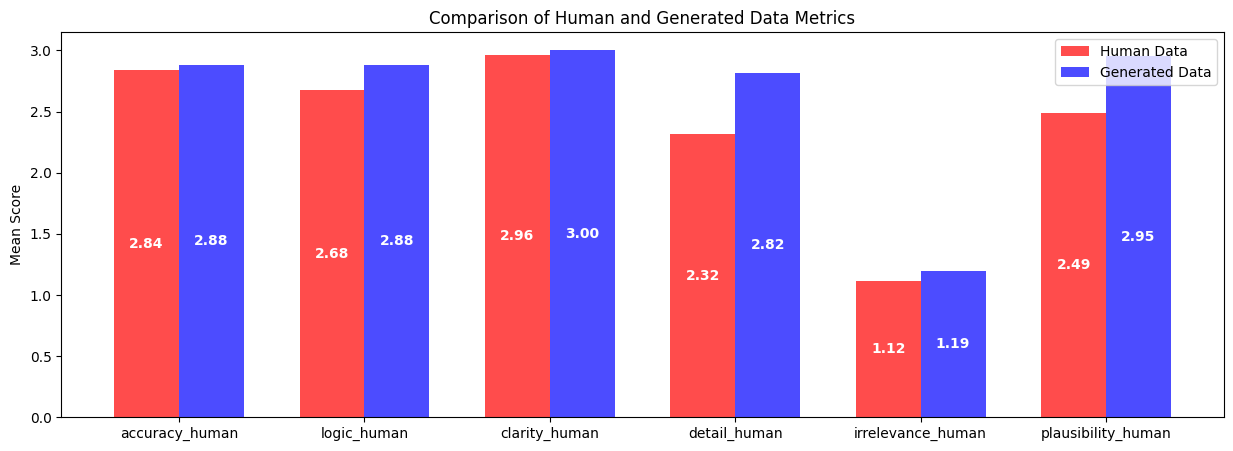

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_human and df_sdg are your DataFrames

# Select relevant columns for comparison
human_metrics = ['accuracy_human', 'logic_human', 'clarity_human', 'detail_human', 'irrelevance_human', 'plausibility_human']
sdg_metrics = ['accuracy', 'logic', 'clarity', 'detail', 'irrelevance', 'plausibility']

# Calculate means for human_metrics and sdg_metrics
human_means = pd.Series((df_human[sdg_metrics].mean().values + df_human[human_metrics].mean().values) / 2, index=sdg_metrics)
sdg_means = pd.Series((df_sdg[sdg_metrics].mean().values + df_sdg[human_metrics].mean().values) / 2, index=sdg_metrics)

# Plotting
fig, ax = plt.subplots(figsize=(15, 5))

# Set the bar width
bar_width = 0.35
bar_positions_human = np.arange(len(human_means))
bar_positions_sdg = bar_positions_human + bar_width

# Plotting the bars
human_bars = ax.bar(bar_positions_human, human_means, width=bar_width, color='red', label='Human Data', alpha=0.7)
sdg_bars = ax.bar(bar_positions_sdg, sdg_means, width=bar_width, color='blue', label='Generated Data', alpha=0.7)

# Add evaluation by VLM as a separate bar within each bar
for human_bar, sdg_bar in zip(human_bars, sdg_bars):
    height_human = human_bar.get_height()
    height_sdg = sdg_bar.get_height()
    ax.text(human_bar.get_x() + human_bar.get_width() / 2, height_human / 2, f'{height_human:.2f}', ha='center', va='center', color='white', fontweight='bold')
    ax.text(sdg_bar.get_x() + sdg_bar.get_width() / 2, height_sdg / 2, f'{height_sdg:.2f}', ha='center', va='center', color='white', fontweight='bold')

# Set labels and title
ax.set_ylabel('Mean Score')
ax.set_title('Comparison of Human and Generated Data Metrics')
ax.set_xticks(bar_positions_human + bar_width / 2)
ax.set_xticklabels(human_metrics)
ax.legend()

# Show the plot
plt.show()


Correlation of all Metrics: 
0.9543609379664285


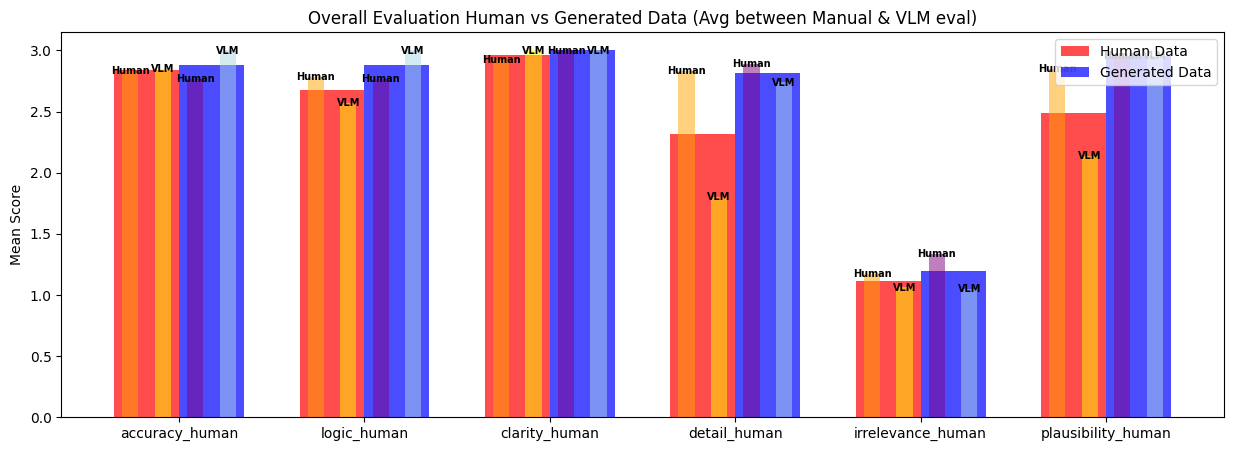

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Assuming df_human and df_sdg are your DataFrames

# Select relevant columns for comparison
human_metrics = ['accuracy_human', 'logic_human', 'clarity_human', 'detail_human', 'irrelevance_human', 'plausibility_human']
sdg_metrics = ['accuracy', 'logic', 'clarity', 'detail', 'irrelevance', 'plausibility']

# Calculate means for human_metrics and sdg_metrics
human_means = pd.Series((df_human[sdg_metrics].mean().values + df_human[human_metrics].mean().values) / 2, index=sdg_metrics)
sdg_means = pd.Series((df_sdg[sdg_metrics].mean().values + df_sdg[human_metrics].mean().values) / 2, index=sdg_metrics)

# Plotting
fig, ax = plt.subplots(figsize=(15, 5))

# Set the bar width
bar_width = 0.35
bar_positions_human = np.arange(len(human_metrics))
bar_positions_sdg = bar_positions_human + bar_width

# Plotting the bars
ax.bar(bar_positions_human, human_means, width=bar_width, color='red', label='Human Data', alpha=0.7)
ax.bar(bar_positions_sdg, sdg_means, width=bar_width, color='blue', label='Generated Data', alpha=0.7)

# Plotting the smaller bars inside each bar
for i, (bar_position_human, bar_position_sdg) in enumerate(zip(bar_positions_human, bar_positions_sdg)):
    ax.bar(bar_position_human - bar_width / 4, df_human[human_metrics].mean().values[i], width=bar_width / 4, color='orange', alpha=0.5)
    ax.bar(bar_position_human + bar_width / 4, df_human[sdg_metrics].mean().values[i], width=bar_width / 4, color='yellow', alpha=0.5)
    ax.bar(bar_position_sdg - bar_width / 4, df_sdg[human_metrics].mean().values[i], width=bar_width / 4, color='purple', alpha=0.5)
    ax.bar(bar_position_sdg + bar_width / 4, df_sdg[sdg_metrics].mean().values[i], width=bar_width / 4, color='lightblue', alpha=0.5)

    # Add annotations for "Human" and "VLM"
    ax.text(bar_position_human - bar_width / 4, df_human[human_metrics].mean().values[i], "Human", ha='center', va='center', color='black', fontweight='bold', fontsize = 7)
    ax.text(bar_position_human + bar_width / 4, df_human[sdg_metrics].mean().values[i], "VLM", ha='center', va='center', color='black', fontweight='bold', fontsize = 7)
    ax.text(bar_position_sdg - bar_width / 4, df_sdg[human_metrics].mean().values[i], "Human", ha='center', va='center', color='black', fontweight='bold', fontsize = 7)
    ax.text(bar_position_sdg + bar_width / 4, df_sdg[sdg_metrics].mean().values[i], "VLM", ha='center', va='center', color='black', fontweight='bold', fontsize = 7)

# Set labels and title
ax.set_ylabel('Mean Score')
ax.set_title('Overall Evaluation Human vs Generated Data (Avg between Manual & VLM eval)')
ax.set_xticks(bar_positions_human + bar_width / 2)
ax.set_xticklabels(human_metrics)
ax.legend()

# Calculate correlation coefficients
correlation_metrics, _ = pearsonr(human_means, sdg_means)

# Display correlation coefficients
print("Correlation of all Metrics: ")
print(correlation_metrics)


# Show the plot
plt.show()


Correlation coefficients - HUMAN DATA KEMIRIPAN ANTAR 2 JUDGE:
0.8048802141560443

Correlation coefficients - GENERATED DATA KEMIRIPAN ANTAR 2 JUDGE
0.9774059281140561


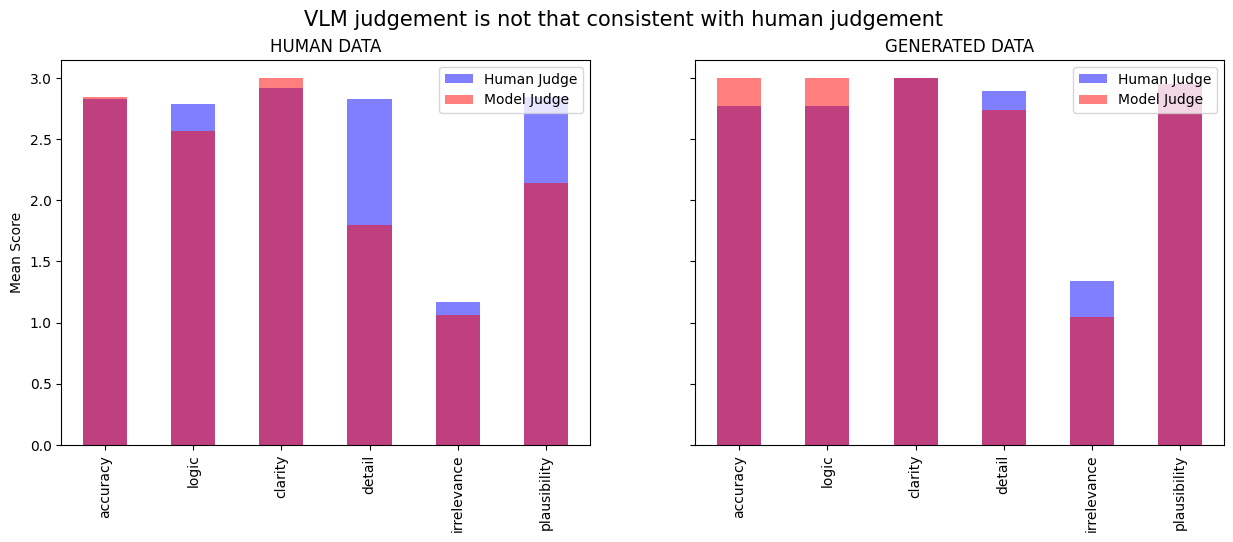

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


# Select relevant columns for comparison
human_metrics = ['accuracy_human', 'logic_human', 'clarity_human', 'detail_human', 'irrelevance_human', 'plausibility_human']
sdg_metrics = ['accuracy', 'logic', 'clarity', 'detail', 'irrelevance', 'plausibility']

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

df_human[human_metrics].mean().plot(kind='bar', ax=ax1, color='blue', label='Human Judge', alpha=0.5)
df_human[sdg_metrics].mean().plot(kind='bar', ax=ax1, color='red', label='Model Judge', alpha=0.5)
df_sdg[human_metrics].mean().plot(kind='bar', ax=ax2, color='blue', label='Human Judge', alpha=0.5)
df_sdg[sdg_metrics].mean().plot(kind='bar', ax=ax2, color='red', label='Model Judge', alpha=0.5)


# Set labels and titles
fig.suptitle("VLM judgement is not that consistent with human judgement", fontsize = 15)

ax1.set_ylabel('Mean Score')
ax1.set_title('HUMAN DATA')
ax1.legend()

ax2.set_title('GENERATED DATA')
ax2.legend()


# Calculate correlation coefficients
correlation_evalby_vlm, _ = pearsonr(df_human[human_metrics].mean(), df_human[sdg_metrics].mean())
correlation_evalby_human, _ = pearsonr(df_sdg[sdg_metrics].mean(), df_sdg[human_metrics].mean())

# Display correlation coefficients
print("Correlation coefficients - HUMAN DATA KEMIRIPAN ANTAR 2 JUDGE:")
print(correlation_evalby_vlm)
print("\nCorrelation coefficients - GENERATED DATA KEMIRIPAN ANTAR 2 JUDGE")
print(correlation_evalby_human)

# Show the plot
plt.show()


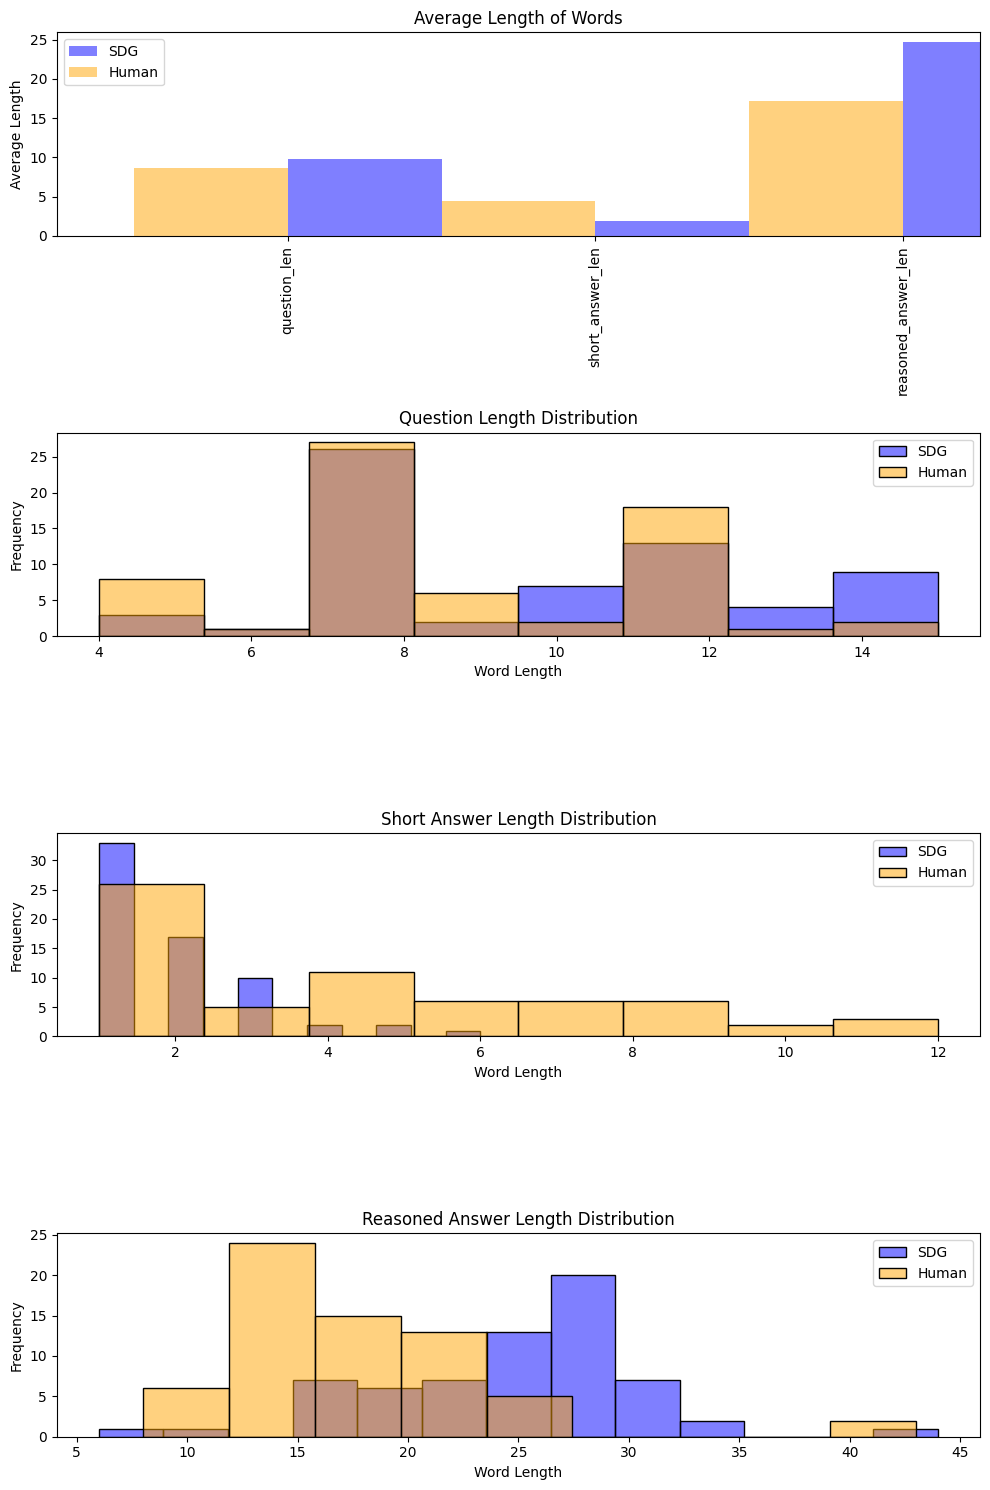

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_sdg and df_human are your dataframes

# Calculate the average length of words for question, short_answer, and reasoned_answer
df_sdg['question_len'] = df_sdg['question'].apply(lambda x: len(x.split()))
df_sdg['short_answer_len'] = df_sdg['short_answer'].apply(lambda x: len(x.split()))
df_sdg['reasoned_answer_len'] = df_sdg['reasoned_answer'].apply(lambda x: len(x.split()))

df_human['question_len'] = df_human['question'].apply(lambda x: len(x.split()))
df_human['short_answer_len'] = df_human['short_answer'].apply(lambda x: len(x.split()))
df_human['reasoned_answer_len'] = df_human['reasoned_answer'].apply(lambda x: len(x.split()))

avg_len_sdg = df_sdg[['question_len', 'short_answer_len', 'reasoned_answer_len']].mean()
avg_len_human = df_human[['question_len', 'short_answer_len', 'reasoned_answer_len']].mean()

df_sdg['question_prefix'] = df_sdg['question'].apply(lambda x: x.split()[0])
df_human['question_prefix'] = df_human['question'].apply(lambda x: x.split()[0])

prefix_count_sdg = df_sdg['question_prefix'].value_counts()
prefix_count_human = df_human['question_prefix'].value_counts()

fig, axes = plt.subplots(4, 1, figsize=(10, 15))

avg_len_sdg.plot(kind='bar', color='blue', alpha=0.5, ax=axes[0], position=0, label='SDG')
avg_len_human.plot(kind='bar', color='orange', alpha=0.5, ax=axes[0], position=1, label='Human')
axes[0].set_title('Average Length of Words')
axes[0].set_ylabel('Average Length')
axes[0].legend()

sns.histplot(df_sdg['question_len'], color='blue', alpha=0.5, ax=axes[1], label='SDG', kde=False)
sns.histplot(df_human['question_len'], color='orange', alpha=0.5, ax=axes[1], label='Human', kde=False)
axes[1].set_title('Question Length Distribution')
axes[1].set_xlabel('Word Length')
axes[1].set_ylabel('Frequency')
axes[1].legend()

sns.histplot(df_sdg['short_answer_len'], color='blue', alpha=0.5, ax=axes[2], label='SDG', kde=False)
sns.histplot(df_human['short_answer_len'], color='orange', alpha=0.5, ax=axes[2], label='Human', kde=False)
axes[2].set_title('Short Answer Length Distribution')
axes[2].set_xlabel('Word Length')
axes[2].set_ylabel('Frequency')
axes[2].legend()

sns.histplot(df_sdg['reasoned_answer_len'], color='blue', alpha=0.5, ax=axes[3], label='SDG', kde=False)
sns.histplot(df_human['reasoned_answer_len'], color='orange', alpha=0.5, ax=axes[3], label='Human', kde=False)
axes[3].set_title('Reasoned Answer Length Distribution')
axes[3].set_xlabel('Word Length')
axes[3].set_ylabel('Frequency')
axes[3].legend()

plt.tight_layout()
plt.show()


Correlation Question Length: -0.0515
Correlation Short Answer Length: 0.2563
Correlation Reasoned Answer Length: -0.1849
Skewness Question Length SDG: 0.2037, Human: 0.2794
Skewness Short Answer Length SDG: 1.5353, Human: 0.7556
Skewness Reasoned Answer Length SDG: -0.3466, Human: 1.8408
Cosine Similarity Matrix Shape: (65, 65)


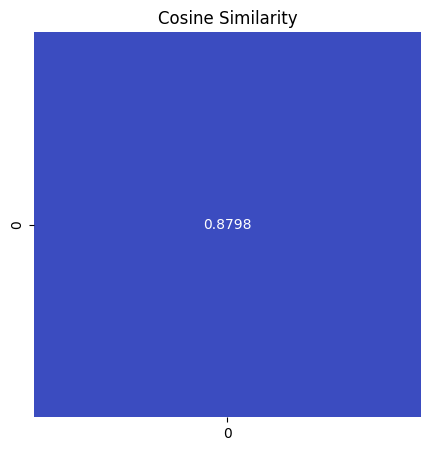

In [12]:
# Calculate and print the correlation values
correlation_question_len, _ = pearsonr(df_sdg['question_len'], df_human['question_len'])
correlation_short_answer_len, _ = pearsonr(df_sdg['short_answer_len'], df_human['short_answer_len'])
correlation_reasoned_answer_len, _ = pearsonr(df_sdg['reasoned_answer_len'], df_human['reasoned_answer_len'])

print(f'Correlation Question Length: {correlation_question_len:.4f}')
print(f'Correlation Short Answer Length: {correlation_short_answer_len:.4f}')
print(f'Correlation Reasoned Answer Length: {correlation_reasoned_answer_len:.4f}')

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, skew
from sklearn.metrics.pairwise import cosine_similarity

# Assuming df_sdg and df_human are your dataframes

# ... (previous code)

# Calculate the average length of words for question, short_answer, and reasoned_answer
# ... (previous code)

# Plotting the histograms
# ... (previous code)

# Calculate and print the correlation values
# ... (previous code)

# Calculate and print skewness
skewness_question_len_sdg = skew(df_sdg['question_len'])
skewness_question_len_human = skew(df_human['question_len'])

skewness_short_answer_len_sdg = skew(df_sdg['short_answer_len'])
skewness_short_answer_len_human = skew(df_human['short_answer_len'])

skewness_reasoned_answer_len_sdg = skew(df_sdg['reasoned_answer_len'])
skewness_reasoned_answer_len_human = skew(df_human['reasoned_answer_len'])

print(f'Skewness Question Length SDG: {skewness_question_len_sdg:.4f}, Human: {skewness_question_len_human:.4f}')
print(f'Skewness Short Answer Length SDG: {skewness_short_answer_len_sdg:.4f}, Human: {skewness_short_answer_len_human:.4f}')
print(f'Skewness Reasoned Answer Length SDG: {skewness_reasoned_answer_len_sdg:.4f}, Human: {skewness_reasoned_answer_len_human:.4f}')

# Calculate and print cosine similarity
feature_columns = ['question_len', 'short_answer_len', 'reasoned_answer_len']
feature_matrix_sdg = df_sdg[feature_columns].values
feature_matrix_human = df_human[feature_columns].values

cosine_sim = cosine_similarity(feature_matrix_sdg, feature_matrix_human)
print(f'Cosine Similarity Matrix Shape: {cosine_sim.shape}')

# Plot the cosine similarity heatmap
plt.figure(figsize=(5, 5))
sns.heatmap([[cosine_sim[0, 0]]], annot=True, cmap='coolwarm', fmt=".4f", cbar=False)
plt.title('Cosine Similarity')
plt.show()


In [150]:
df_human['question_len']

0      7
1      7
2     11
3      6
4      9
      ..
60    14
61     7
62     5
63    12
64     9
Name: question_len, Length: 65, dtype: int64

In [152]:
df_human.shape

(65, 23)

In [151]:
df_sdg['question_len']

0      8
1      8
2      5
3      7
4     10
      ..
70    12
71    11
72    14
73    11
74    10
Name: question_len, Length: 75, dtype: int64

In [122]:
len(df_sdg['question_len']), len(df_human['question_len'])

(75, 90)

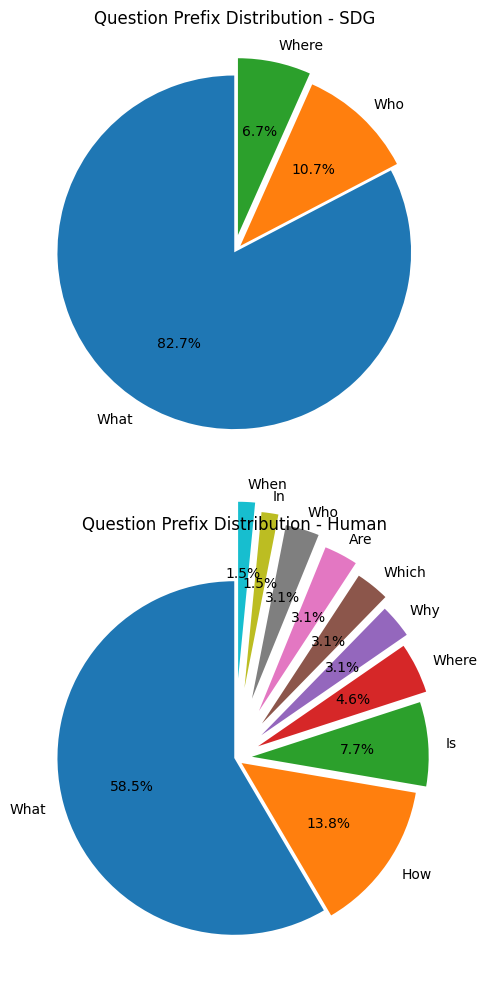

In [149]:
# Pie chart figure
fig2, axes2 = plt.subplots(2, 1, figsize=(8, 10))

# Prefix distribution comparison as exploding pie chart
explode_sdg = tuple([0.05 * i for i in range(len(prefix_count_sdg))])
explode_human = tuple([0.05 * i for i in range(len(prefix_count_human))])

axes2[0].pie(prefix_count_sdg, labels=prefix_count_sdg.index, autopct='%1.1f%%', startangle=90, explode=explode_sdg)
axes2[0].set_title('Question Prefix Distribution - SDG')

axes2[1].pie(prefix_count_human, labels=prefix_count_human.index, autopct='%1.1f%%', startangle=90, explode=explode_human)
axes2[1].set_title('Question Prefix Distribution - Human')

plt.tight_layout()
plt.show()

In [15]:
df_sdg_data.to_excel('sdg.xlsx')